- Can we find heuristics (probably from the unaltered filtration) about which additional edges the adversaries are likely to add?

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pt_activation.models.cff_sigmoid import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/carliniwagnerl2/cff_sigmoid.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 0, 'pin_memory': False}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 28*28))
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(28*28)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    ims = np.empty((up_to, 28*28))
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=0, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)
                ims[s+t,:] = data[s].numpy().reshape(28*28)
            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms, ims

def get_adv_dist(i,j):
    return np.linalg.norm(i-j,2)

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/cff_sigmoid.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, nms, wms, ims = create_filtrations(model, 10, 10)

/home/tgebhart/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Filtration: 0
filtration size 77275
Filtration: 1
filtration size 142673
Filtration: 2
filtration size 17357
Filtration: 3
filtration size 100185
Filtration: 4
filtration size 59808
Filtration: 5
filtration size 12070
Filtration: 6
filtration size 103369
Filtration: 7
filtration size 86325
Filtration: 8
filtration size 38112
Filtration: 9
filtration size 23850


In [7]:
adv_df, adv_nms, adv_wms, adv_ims = create_adversary_filtrations(model, 10, 10, adversaries)

torch.Size([194, 1, 28, 28])
Filtration: 0
filtration size 9572
Filtration: 1
filtration size 77275
Filtration: 2
filtration size 144309
Filtration: 3
filtration size 7828
Filtration: 4
filtration size 91745
Filtration: 5
filtration size 106766
Filtration: 6
filtration size 59808
Filtration: 7
filtration size 67517
Filtration: 8
filtration size 14605
Filtration: 9
filtration size 12070


In [8]:
print('Adversary Accuracy:', adv_df[adv_df['prediction'] == adv_df['class']].shape[0]/adv_df.shape[0])
print('Actual Accuracy:', res_df[res_df['prediction'] == res_df['class']].shape[0]/res_df.shape[0])

Adversary Accuracy: 0.4
Actual Accuracy: 0.9


In [9]:
ids = [{v: k for k, v in nm.items()} for nm in nms]
adv_ids = [{v: k for k, v in nm.items()} for nm in adv_nms]

In [10]:
def create_sample_graphs(res_df, ids, wms):
    sample_graphs = []
    dgms = []
    lifetimes = []
    for s in range(res_df.shape[0]):
        print(s)
        wm = wms[s]
        tnms = ids[s]
        subgraphs = {}
        f = res_df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgm = dion.init_diagrams(m,f)[0]
        dgms.append(dgm)
        for i,c in enumerate(m):
            if len(c) == 2:
                w = f[i].data
                if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                    w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
                elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                    w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
                if False: #tnms[f[c[0].index][0]] in subgraphs:
                    subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(tnms[f[c[0].index][0]]):
                            if tnms[f[c[1].index][0]] in subgraphs:
                                v.add_node(f[c[1].index][0])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                            else:
                                v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        subgraphs[tnms[f[c[0].index][0]]] = g
                        
        sample_graphs.append(subgraphs)
        lifetimes.append(create_lifetimes(f, subgraphs,dgm,ids[s]))
    return sample_graphs, dgms, lifetimes

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]] 
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes


In [11]:
sample_graphs, dgms, lifetimes = create_sample_graphs(res_df, ids, wms)

0
1
2
3
4
5
6
7
8
9


In [12]:
adv_sample_graphs, adv_dgms, adv_lifetimes = create_sample_graphs(adv_df, adv_ids, adv_wms)

0
1
2
3
4
5
6
7
8
9


In [13]:
adv_df.head(10)

,class,filtration,loss,prediction
0,7,"[(858), (881), (834), (857), (904), (905), (88...",-5.531286,9
1,7,"[(4144), (4202), (4144, 4202), (429), (352), (...",-8.079765,7
2,2,"[(1093), (1069), (1094), (1070), (1046), (1071...",-3.838098,3
3,1,"[(664), (688), (640), (759), (1020), (735), (9...",-5.176184,2
4,0,"[(1020), (1068), (5495), (5756), (5495, 5756),...",-0.769773,5
5,0,"[(1020), (996), (1019), (973), (995), (972), (...",-0.136930,0
6,4,"[(464), (465), (482), (555), (556), (630), (63...",-7.923283,4
7,4,"[(763), (1000), (753), (787), (739), (977), (1...",-4.377320,7
8,1,"[(784), (1115), (760), (1091), (759), (735), (...",-8.244882,7
9,1,"[(243), (253), (254), (262), (263), (272), (27...",-12.007354,1


In [14]:
goi = 4

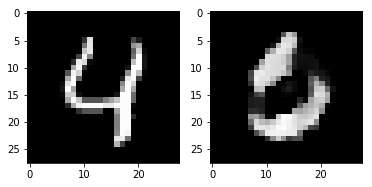

In [15]:
plt.subplot(121).imshow(ims[goi].reshape(28,28), cmap='gray')
plt.subplot(122).imshow(adv_ims[goi].reshape(28,28), cmap='gray')

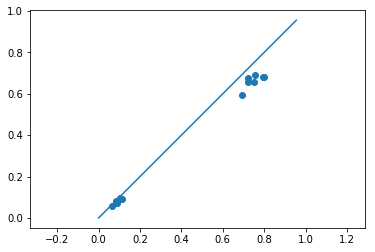

In [16]:
dion.plot.plot_diagram(dgms[goi])

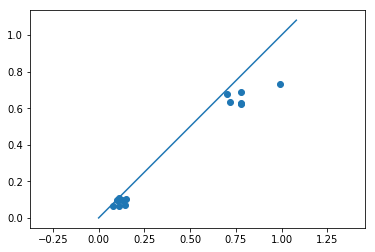

In [17]:
dion.plot.plot_diagram(adv_dgms[goi])

In [18]:
lifetimes[goi]

{(2, 0, 2): 0.8102291226387024,
 (2, 0, 33): 0.1197885274887085,
 (2, 0, 11): 0.11439263820648193,
 (2, 0, 4): 0.06337833404541016,
 (2, 0, 22): 0.09526622295379639,
 (2, 0, 3): 0.04925030469894409,
 (2, 0, 24): 0.06530237197875977,
 (2, 0, 14): 0.09480071067810059,
 (1, 0, 2676): 0.019762098789215088,
 (1, 0, 1407): 0.019003331661224365,
 (1, 0, 2550): 0.003087960183620453,
 (1, 0, 705): 0.016604013741016388,
 (1, 0, 2674): 0.0070635974407196045,
 (1, 0, 282): 0.0032605379819869995,
 (1, 0, 2648): 0.01279488205909729,
 (1, 0, 2681): 0.006276041269302368}

In [19]:
adv_lifetimes[goi]

{(2, 0, 5): 1.0639463663101196,
 (2, 0, 2): 0.2566026449203491,
 (2, 0, 34): 0.08996695280075073,
 (2, 0, 11): 0.1549552083015442,
 (2, 0, 32): 0.14675366878509521,
 (2, 0, 14): 0.08443057537078857,
 (2, 0, 27): 0.021320879459381104,
 (2, 0, 45): 0.04166015237569809,
 (2, 0, 42): 0.031678974628448486,
 (1, 0, 874): 0.002962537109851837,
 (1, 0, 828): 0.006630174815654755}

In [20]:
sgk = (2,0,34)
# agk = (2,0,34)
agk = sgk

In [21]:
mw = max([abs(edge[2]['weight']) for edge in sample_graphs[goi][sgk].edges(data=True)])
amw = max([abs(edge[2]['weight']) for edge in adv_sample_graphs[goi][agk].edges(data=True)])

widths = [abs(edge[2]['weight'])/mw + 0.1 for edge in sample_graphs[goi][sgk].edges(data=True)]
adv_widths = [abs(edge[2]['weight'])/amw + 0.1 for edge in adv_sample_graphs[goi][agk].edges(data=True)]

KeyError: (2, 0, 34)

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 1,
    'width': widths,
    'with_labels':True}
nx.draw_circular(sample_graphs[goi][sgk], **options)

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 1,
    'width': adv_widths,
    'with_labels':True}
nx.draw_circular(adv_sample_graphs[goi][agk], **options)

In [ ]:
sample_graphs[goi][sgk].edges(data=True)

In [ ]:
adv_sample_graphs[goi][agk].edges(data=True)

In [ ]:
intersection = set(sample_graphs[goi][sgk].edges()).intersection(set(adv_sample_graphs[goi][agk].edges()))
intersection

In [ ]:
difference = set(adv_sample_graphs[goi][agk].edges()).difference(set(sample_graphs[goi][sgk].edges()))
difference

In [ ]:
sorted_wm = sorted(list(wms[goi].values()))

In [ ]:
for k in difference:
    try:
        print(k, wms[goi][k])
    except KeyError:
        try:
#             
            print('rev', k, wms[goi][(k[1],k[0])], sorted_wm.index(wms[goi][(k[1],k[0])])/len(sorted_wm))
        except KeyError:
            pass
            print('cant do it', k)